# Introduction

Cet exercice va vous permettre de vous familiariser avec le concept de stacking sur un dataset que vous connaissez déjà, il s'agit du dataset Titanic

On commencera par importer les librairies nécessaires.

In [0]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Feature Exploration, Engineering and Cleaning 

1. afficher les premières lignes du dataset

In [0]:
# Load in the train and test datasets
data = pd.read_csv("https://raw.githubusercontent.com/JedhaBootcamp/FULL_STACK_12_WEEK_PROGRAM/master/S0.4%20--%20R%C3%A9duction%20de%20Dimensions%20%26%20Boosting/S4-4%20--%20Ensemble%20Learning/Dataset/titanic.csv?token=AFB53D7JRIVKGC6ZOYPRYZK6HVYLQ")

data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


2. A quels types de variables avez vous affaire, quels types de traitements pourriez vous faire afin de créer un dataset compatible avec un modèle de ML.
Appliquez les méthodes de preprocessing choisies.

3. Si l'inspiration vous manque, voici quelques idées de nettoyage et création de variables.

a. créez une variable Name_length qui contient la longueur de la variable Name

In [0]:
# Some features of my own that I have added in
# Gives the length of the name
data['Name_length'] = data['Name'].apply(len)

b. Créez une variable Has_Cabin qui indique si oui ou non le passager possède une cabine.

In [0]:
# Feature that tells whether a passenger had a cabin on the Titanic
data['Has_Cabin'] = data["Cabin"].apply(lambda x: 0 if pd.isnull(x) else 1)
data['Has_Cabin']

0      0
1      1
2      0
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Has_Cabin, Length: 891, dtype: int64

c. Créez une variable FamilySize qui donne la taille de la famille des passagers

In [0]:
# Create new feature FamilySize as a combination of SibSp and Parch
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

d. Créez une variable IsAlone qui indique si le passager a des membres de sa famille à bord ou non.

In [0]:
# Create new feature IsAlone from FamilySize
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

e. Remplacez les valeurs manquantes de la variables Embarked

In [0]:
# Remove all NULLS in the Embarked column
data['Embarked'] = data['Embarked'].fillna('S')

f. Remplacez les valeurs manquantes de Fare par la médiane. Vous pouvez utiliser une méthode plus judicieuse si vous le souhaitez.

In [0]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [0]:
data.groupby("Pclass").median()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_length,Has_Cabin,FamilySize,IsAlone
Pclass,,,,,,,,,,
1,472.0,1.0,37.0,0.0,0.0,60.2875,27.0,1.0,1.0,1.0
2,435.5,0.0,29.0,0.0,0.0,14.2500,26.0,0.0,1.0,1.0
3,432.0,0.0,24.0,0.0,0.0,8.0500,24.0,0.0,1.0,1.0


g. Créez une variable CategoricalFare grâce à la fonction pd.qcut afin de produire 4 tranches.

In [0]:
data['CategoricalFare'] = pd.qcut(data['Fare'], 4,labels=False)

h. Remplacez les valeurs manquantes pour l'âge grâce à la technique de votre choix.

In [0]:
age_avg = data['Age'].mean()
age_std = data['Age'].std()
age_null_count = data['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
data['Age'][np.isnan(data['Age'])] = age_null_random_list

i. Créez une variable CategoricalAge qui correspond à 5 tranches d'âge

In [0]:
# Create a New feature CategoricalAge

data['Age'] = data['Age'].astype(int)
data['CategoricalAge'] = pd.cut(data['Age'], 5,labels=False)

j. Grâce à la fonction suivante re.search(' ([A-Za-z]+)\.', name) extrayez le titre de chaque passager afin de créer une variable Title

In [0]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
data['Title'] = data['Name'].apply(get_title)

k. Est ce que certains titres sont très sous-représentés par rapport aux autres ? Si c'est le cas, remplacez ces valeurs par une catégorie unique "Rare"

In [0]:
# Group all non-common titles into one single grouping "Rare"
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')


l. Si certains titres sont équivalents convertissez les tous dans une seule catégories, par exemple Mlle = Miss, donc on peut remplacer tout les Mlle par Miss

In [0]:
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

m. Convertissez la variable Sex au format numérique

In [0]:
# Mapping Sex
data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

n. Convetissez la variable Title au format numérique

In [0]:
# Mapping titles
titles= pd.get_dummies(data['Title'], drop_first=True)
data = data.drop('Title', axis=1)
data = data.join(titles)

o. Convertissez la variable Embarked au format numérique

In [0]:
# Mapping Embarked
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

p.Créez une variable FareCategorical comme la transformée de Fare en 4 catégories.

In [0]:
# Mapping Fare
data['FareCategorical'] = 0
data.loc[ data['Fare'] <= 7.91, 'FareCategorical'] 						        = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'FareCategorical'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'FareCategorical']   = 2
data.loc[ data['Fare'] > 31, 'FareCategorical'] 							        = 3
data['FareCategorical'] = data['FareCategorical'].astype(int)

4. Supprimez les colonnes 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp' du dataset, pourquoi n'en avons nous plus besoin par la suite ?

In [0]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
data = data.drop(drop_elements, axis = 1)


## Visualisations 

Maintenant que nous avons nettoyé le dataset lançons nous dans la visualisation de nos données.

In [0]:
data.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Miss,Mr,Mrs,Rare,FareCategorical
0,0,3,1,22,0,7.2500,0,23,0,2,0,0,1,0,1,0,0,0
1,1,1,0,38,0,71.2833,1,51,1,2,0,3,2,0,0,1,0,3
2,1,3,0,26,0,7.9250,0,22,0,1,1,1,1,1,0,0,0,1


**Pearson Correlation Heatmap**

5. Générez une figure qui contient le tableau des corrélations entre les différentes variables du dataset, quelles sont vos interprétations?

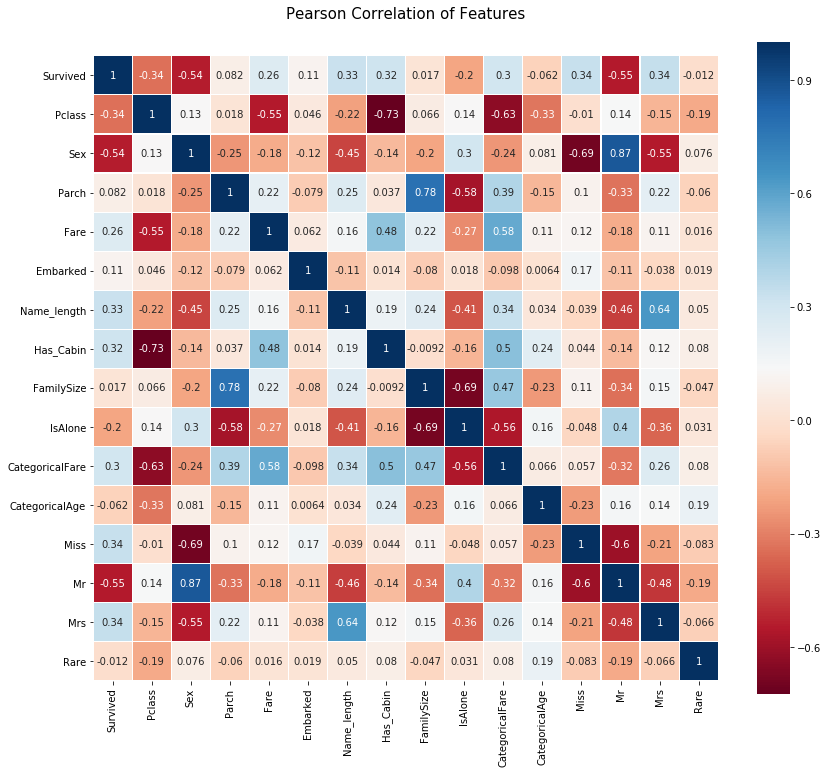

In [0]:
data = data.drop(["FareCategorical", "Age"],axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Les corrélations entre les variables explicatives ne sont pas trop élevées, nous pouvons donc espérer qu'elles apporteront chacune des informations complémentaire pour entraîner un modèle.

**Pairplots**

6. Générez des pairplots entre différentes variables explicatives afin de comprendre mieux les liens qui existent entre elles.

In [0]:
g = sns.pairplot(data[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

NameError: ignored

# Ensembling & Stacking models

Maintenant que nous avons avancé dans le preprocessing et la création de variables nous pouvons commencer à préparer notre modèle de stacking.

# Generating our Base First-Level Models 

Nous allons maintenant préparer les modèles de la première couche de notre stacking!

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

 7. Créez une instance rf de RandomForestClassifier

In [0]:
rf = RandomForestClassifier(n_estimators=500, max_depth=6, max_features='sqrt')

8. Créez une instance d'un ExtraTreeClassifier

In [0]:
et =  ExtraTreesClassifier(n_estimators=500, max_depth=6)

9. Créez une instance d'AdaboostClassifier

In [0]:
ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.75)

10. Créez une instance de GradientBoostingClassifier

In [0]:
gb = GradientBoostingClassifier(n_estimators=500, max_depth=6)

11. Créez une instance de SVC

In [0]:
svc = SVC(kernel='linear', C= 0.025, probability=True)

12. A partir de l'objet data, créez quatre objets x_train, x_test, y_train et y_test en vue d'entraîner nos modèles de la première couche.
On séparera également x_train et y_train en deux parties x_train1 y_train1 et x_train2 et y_train2, en effet la première partie servira à entraîner les modèles de la première couche (ou base models) et la deuxième partie que l'on transformera grâce aux bases models serivira à entraîner le modèle de la deuxième couche ou meta-model.
Ceci permet d'assurer l'indépendance entre les données d'entraînement des deux couches et de limiter ainsi le sur-apprentissage.

In [0]:
X = data.drop('Survived', axis = 1)
y =  data['Survived']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify =y)

x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train, test_size = 0.5, stratify=y_train)

13. Entraînez les base models sur x_train1 et y_train1, contruisez les vecteurs de prédictions des 5 base models à partir de x_train2 et de x_test.

In [0]:
rf.fit(X = x_train1, y = y_train1)
et.fit(X = x_train1, y = y_train1)
ada.fit(X = x_train1, y = y_train1)
gb.fit(X = x_train1, y = y_train1)
svc.fit(X = x_train1, y = y_train1)

rf_train_pred = rf.predict_proba(x_train2)
et_train_pred = et.predict_proba(x_train2)
ada_train_pred = ada.predict_proba(x_train2)
gb_train_pred = gb.predict_proba(x_train2)
svc_train_pred = svc.predict_proba(x_train2)

rf_test_pred = rf.predict_proba(x_test)
et_test_pred = et.predict_proba(x_test)
ada_test_pred = ada.predict_proba(x_test)
gb_test_pred = gb.predict_proba(x_test)
svc_test_pred = svc.predict_proba(x_test)

print("Training is complete")

Training is complete


**Feature importances à partir des différents prédicteurs**

14. Utilisez les différents modèles afin de calculer l'importances des différentes variables.

In [0]:
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
ada_feature = ada.feature_importances_
gb_feature = gb.feature_importances_

15. créez un dataframe contenant les feature_importance de chaque variable

In [0]:
cols = X.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    }, index = cols)
feature_dataframe

,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
Pclass,0.048928,0.065918,0.010,0.055770
Sex,0.197182,0.257268,0.008,0.040174
Age,0.077379,0.027220,0.156,0.127137
Parch,0.016592,0.011582,0.038,0.003010
Fare,0.096716,0.028826,0.438,0.137520
Embarked,0.018569,0.016555,0.012,0.017976
Name_length,0.104266,0.036426,0.240,0.125561
Has_Cabin,0.022948,0.039675,0.010,0.006433
FamilySize,0.043201,0.021513,0.042,0.043190
IsAlone,0.011438,0.020364,0.006,0.002787


16. Visualisez l'importance des variables via la figure qui vous semble la plus adaptée


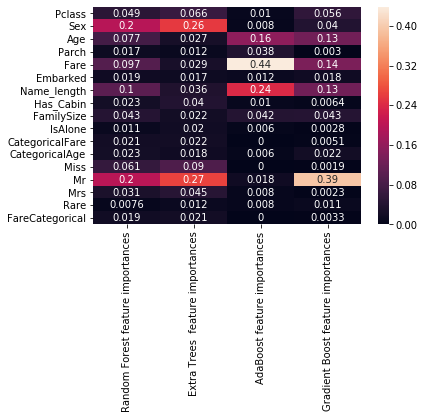

In [0]:
import seaborn as sns
sns.heatmap(feature_dataframe,annot=True)

17. Créez une nouvelle colonne contenant la moyenne des feature importance pour chaque variable.

In [0]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
Pclass,0.048928,0.065918,0.010,0.055770,0.045154
Sex,0.197182,0.257268,0.008,0.040174,0.125656
Age,0.077379,0.027220,0.156,0.127137,0.096934


# Second-Level Predictions from the First-level Output

**First-level output as new features**

18. Maintenant que nous avons nos prédictions du premier niveau, nous allons pouvoir entraîner notre modèle de niveau deux.
Commencez par former un data frame base_predictions_train qui contient les prédictions des base models pour x_train2 et un objet base_predictions_test qui contient les prédictions des base models pour x_test.

In [0]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_train_pred[:,1],
     'ExtraTrees': et_train_pred[:,1],
     'AdaBoost': ada_train_pred[:,1],
      'GradientBoost': gb_train_pred[:,1],
      'svc': svc_train_pred[:,1]
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,svc
0,0.237284,0.244166,0.499362,0.142979,0.149054
1,0.791985,0.739162,0.519514,0.999943,0.786991
2,0.974692,0.973555,0.505805,0.999986,0.857584
3,0.079716,0.082001,0.497547,0.001532,0.095417
4,0.047955,0.077020,0.497337,0.000162,0.104345


In [0]:
base_predictions_test = pd.DataFrame( {'RandomForest': rf_test_pred[:,1],
     'ExtraTrees': et_test_pred[:,1],
     'AdaBoost': ada_test_pred[:,1],
      'GradientBoost': gb_test_pred[:,1],
      'svc': svc_test_pred[:,1]
    })
base_predictions_test.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,svc
0,0.533975,0.403214,0.504471,0.999663,0.442432
1,0.175028,0.096610,0.500002,0.046035,0.135556
2,0.070399,0.080751,0.496142,0.000241,0.103724
3,0.344815,0.193305,0.501824,0.999849,0.172302
4,0.950038,0.940329,0.503442,0.999972,0.829829


**Correlation Heatmap of the Second Level Training set**
19. Produisez une heatmap des corrélations entre les nouvelles variables


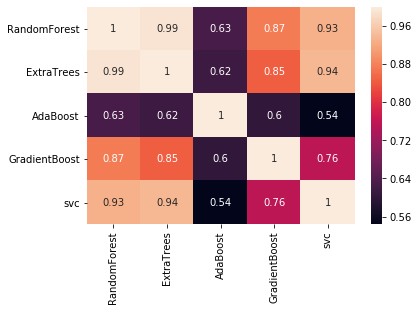

In [0]:
 sns.heatmap(base_predictions_train.corr()
    , annot = True)


En général on préfère des modèles qui donnent des prédictions le moins corellées entre elles possible.

### Second level learning model via XGBoost

20. Créez une instance d'un modèle XGBoost XGBClassifier avec n_estimators= 2000, max_depth= 4 
Entraînez le sur vos nouvelles données de train et créez un objet predictions qui rassemblera les prédictions sur le test.

In [0]:
gbm = xgb.XGBClassifier(
 n_estimators= 2000,
 max_depth= 2,  learning_rate = 0.001).fit(base_predictions_train, y_train2)
predictions = gbm.predict(base_predictions_test)

21. Quel est le score du modèle de niveau 2 ? Comment l'interprétez vous ? A quelles autres métriques pourrions nous le comparer?

In [0]:
gbm.score(base_predictions_train, y_train2)

0.848314606741573

In [0]:
gbm.score(base_predictions_test, y_test)

0.8156424581005587

In [0]:
rf.score(x_train2,y_train2)

0.8061797752808989

In [0]:
rf.score(x_test,y_test)

0.8156424581005587

In [0]:
from sklearn.ensemble import StackingClassifier
st = StackingClassifier([])